# 2. 간단한 데이터 탐색


현재 시점 : 형태소 분석 -> 풍자(감정유형)의 종류도 태깅 완료 이제는 감정 유형 분포 확인

시점별 감정유형 분석 완료
결과 CSV 저장: /Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_시점별_감정유형분포.csv


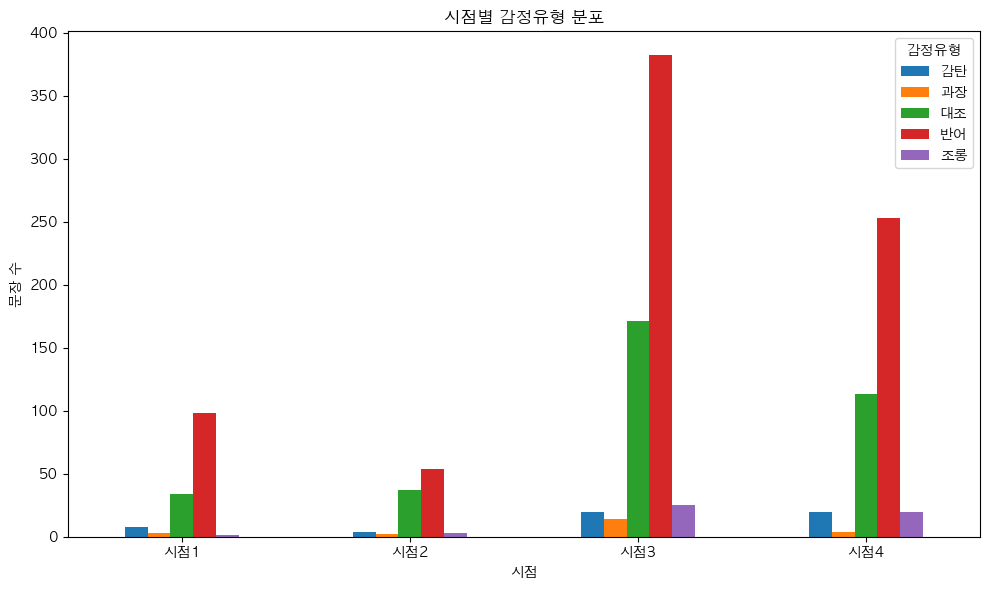

In [ ]:
from collections import Counter
import matplotlib.pyplot as plt

path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_감정유형태깅_최종.csv"
df = pd.read_csv(path)

# 시점 범위 (책 읽고 직접 추출 - 시점별로 )
slices = {
    "시점1": (1, 549),
    "시점2": (550, 1100),
    "시점3": (1101, 3654),
    "시점4": (3655, df["문장번호"].max())
}

results = []

# 시점별 감정유형 카운트
for stage, (start, end) in slices.items():
    sub = df[(df["문장번호"] >= start) & (df["문장번호"] <= end)]
    emotions = []
    for val in sub["감정유형"].dropna():
        emotions += [e.strip() for e in val.split(",") if e.strip()]
    count = Counter(emotions)
    for emotion, freq in count.items():
        results.append({"시점": stage, "감정유형": emotion, "빈도수": freq})

# 데이터프레임으로 정리
summary = pd.DataFrame(results)
pivot = summary.pivot(index="감정유형", columns="시점", values="빈도수").fillna(0).astype(int)

# 저장
pivot_path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_시점별_감정유형분포.csv"
pivot.to_csv(pivot_path, encoding="utf-8-sig")

import matplotlib as mpl
mpl.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 시각화
pivot.T.plot(kind="bar", figsize=(10, 6), title="시점별 감정유형 분포")
plt.xlabel("시점")
plt.ylabel("문장 수")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/시점별_감정유형_분포그래프.png")

print("시점별 감정유형 분석 완료")
print("결과 CSV 저장:", pivot_path)


시점별 문장의 양이 다르기 때문에 비율로 계산해봐야 한다

 시점별 감정유형 비율 분석 완료
 저장: /Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_시점별_감정유형비율.csv


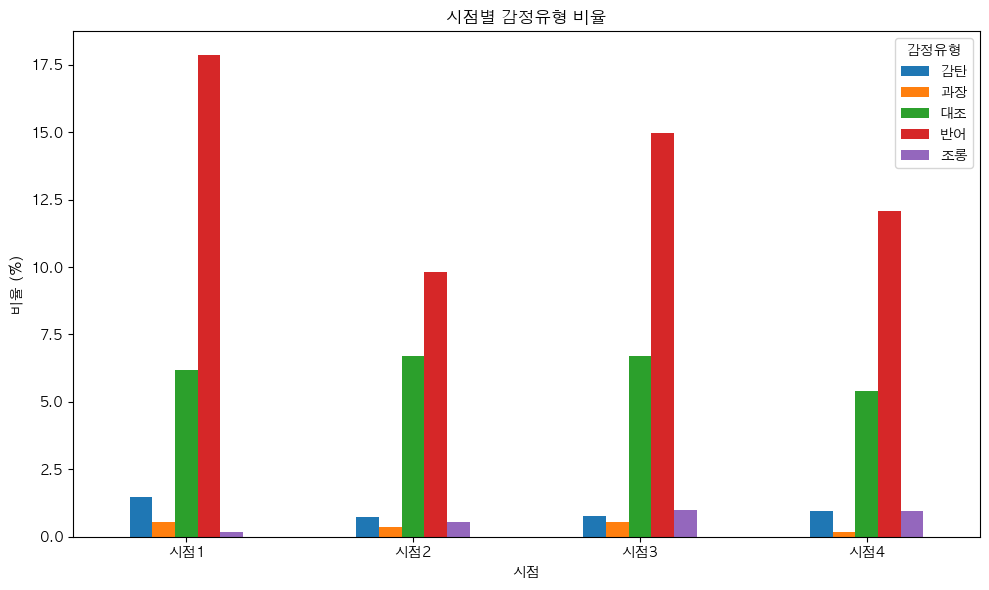

In [ ]:
path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_감정유형태깅_최종.csv"
df = pd.read_csv(path)

# 시점 범위 정의
slices = {
    "시점1": (1, 549),
    "시점2": (550, 1100),
    "시점3": (1101, 3654),
    "시점4": (3655, df["문장번호"].max())
}

# 감정유형 카운트 → 비율 변환
results = []

for stage, (start, end) in slices.items():
    sub = df[(df["문장번호"] >= start) & (df["문장번호"] <= end)]
    total = len(sub)
    emotions = []
    for val in sub["감정유형"].dropna():
        emotions += [e.strip() for e in val.split(",") if e.strip()]
    count = Counter(emotions)
    for emotion, freq in count.items():
        percent = round(freq / total * 100, 2)
        results.append({"시점": stage, "감정유형": emotion, "비율(%)": percent})

# 데이터 정리
summary = pd.DataFrame(results)
pivot = summary.pivot(index="감정유형", columns="시점", values="비율(%)").fillna(0)

# 저장
pivot_path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_시점별_감정유형비율.csv"
pivot.to_csv(pivot_path, encoding="utf-8-sig")

# 시각화
pivot.T.plot(kind="bar", figsize=(10, 6), title="시점별 감정유형 비율")
plt.xlabel("시점")
plt.ylabel("비율 (%)")
plt.xticks(rotation=0)
plt.tight_layout()
plt.savefig("/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/시점별_감정유형_비율그래프.png")

print(" 시점별 감정유형 비율 분석 완료")
print(" 저장:", pivot_path)


비율로 보니까 좀 정리되는것 같은데,, 반어가 앞도적으로 높은 이유가 뭘까 반어의 감정유형이 제일 포괄적이어서 그런가


vetotizing 부터 해보자 tf-idf

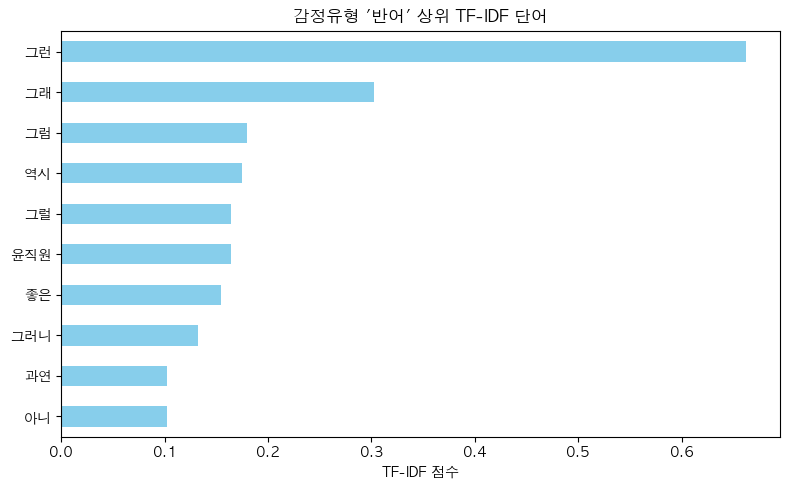

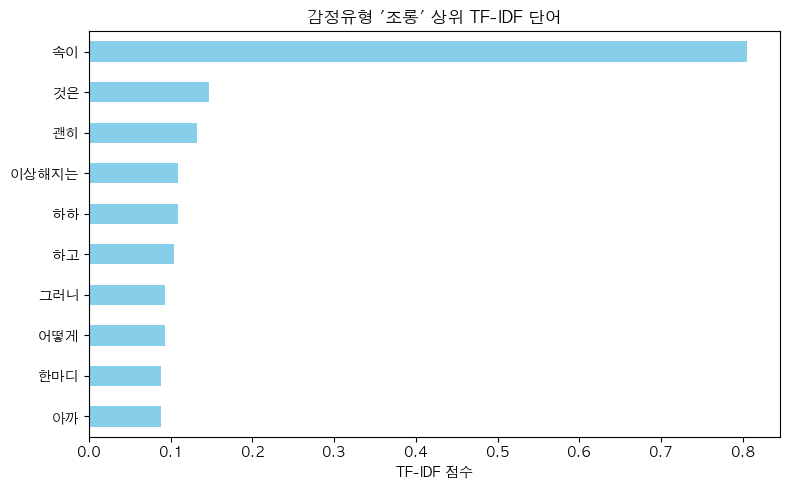

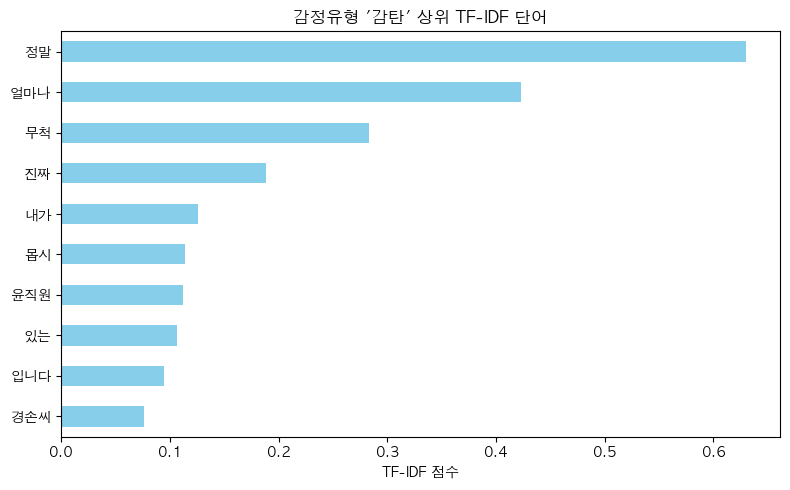

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer


mpl.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로 설정
path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_감정유형태깅_최종.csv"
df = pd.read_csv(path)

# 결측 제거
df = df.dropna(subset=["감정유형", "문장내용"])

# 감정유형 열이 문자열일 경우 쉼표로 분리
df["감정유형"] = df["감정유형"].astype(str).str.split(",")

# explode로 분리
df = df.explode("감정유형")
df["감정유형"] = df["감정유형"].str.strip()

# 감정유형별 문장 결합
grouped = df.groupby("감정유형")["문장내용"].apply(lambda x: " ".join(x)).reset_index()

# TF-IDF 벡터화
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(grouped["문장내용"])
tfidf_df = pd.DataFrame(X.toarray(), index=grouped["감정유형"], columns=vectorizer.get_feature_names_out())

# 감정유형별 상위 단어 시각화 함수
def plot_top_keywords(emotion, top_n=10):
    if emotion not in tfidf_df.index:
        print(f"⚠️ 감정유형 '{emotion}' 없음")
        return
    keywords = tfidf_df.loc[emotion].sort_values(ascending=False)[:top_n]
    plt.figure(figsize=(8, 5))
    keywords.plot(kind="barh", color="skyblue")
    plt.gca().invert_yaxis()
    plt.title(f"감정유형 '{emotion}' 상위 TF-IDF 단어")
    plt.xlabel("TF-IDF 점수")
    plt.tight_layout()
    plt.show()

# 예시: 반어, 조롱, 감탄
plot_top_keywords("반어")
plot_top_keywords("조롱")
plot_top_keywords("감탄")



시점1기준으로 tf-idf 계산하고 비율 확인해보기

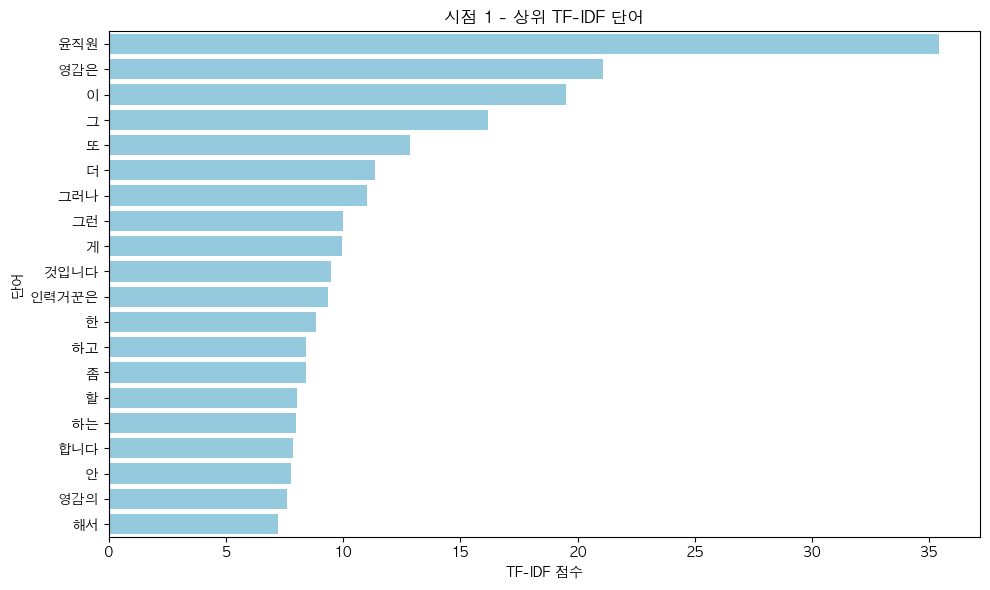

In [ ]:
import seaborn as sns

# 한글 폰트 설정 (Mac)
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# 파일 경로
file_path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_감정유형태깅_최종.csv"

# CSV 로드
df = pd.read_csv(file_path)

# 시점 1 문장 범위 지정
df_s1 = df[df["문장번호"] <= 549].dropna(subset=["문장내용"])

# TF-IDF 벡터라이저 정의
vectorizer = TfidfVectorizer(max_features=100, token_pattern=r"(?u)\b\w+\b")
X = vectorizer.fit_transform(df_s1["문장내용"])
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 단어별 TF-IDF 합산값 정렬
top_keywords = tfidf_df.sum().sort_values(ascending=False).head(20)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, color="skyblue")
plt.title("시점 1 - 상위 TF-IDF 단어")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()
plt.show()


품사필터링 걸고 하고 그다음 n그램방식으로 지금은 좀 애매하지 

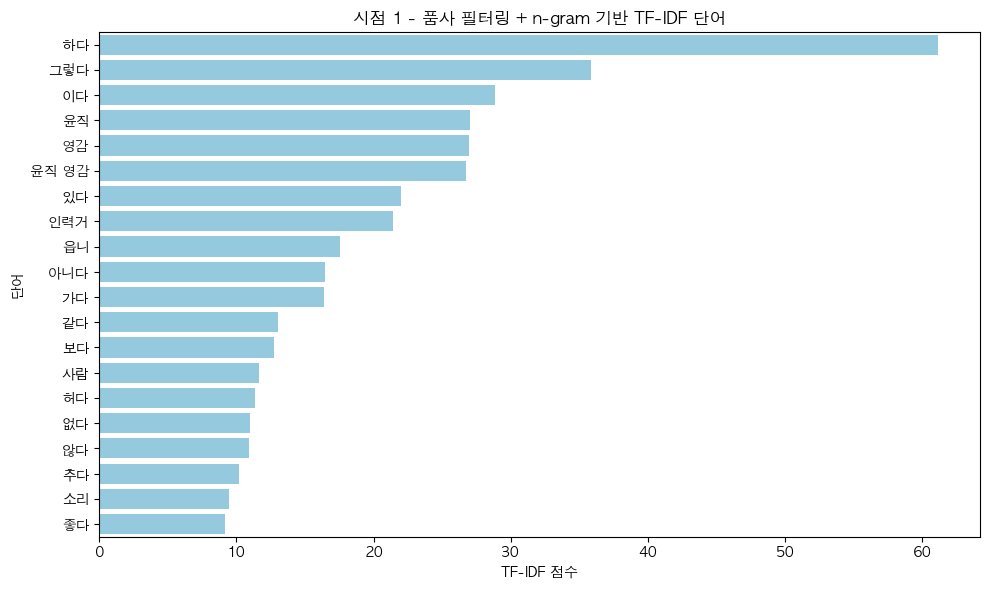

In [ ]:
file_path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_감정유형태깅_최종.csv"
df = pd.read_csv(file_path)

# 시점 1 범위 필터링
df_s1 = df[df["문장번호"] <= 549].dropna(subset=["문장내용"])

# 형태소 분석기 준비
okt = Okt()

# 명사, 형용사, 동사만 걸어보기 필터링
def get_filtered_tokens(text):
    return [word for word, tag in okt.pos(text, stem=True) if tag in ['Noun', 'Adjective', 'Verb']]

# 문장별로 토큰화 수행
tokenized_docs = df_s1["문장내용"].apply(get_filtered_tokens).tolist()
joined_docs = [" ".join(tokens) for tokens in tokenized_docs]

# TF-IDF 벡터라이저: unigram + bigram
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=100)
X = vectorizer.fit_transform(joined_docs)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 단어별 TF-IDF 점수 합산 후 상위 20개 추출
top_keywords = tfidf_df.sum().sort_values(ascending=False).head(20)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, color="skyblue")
plt.title("시점 1 - 품사 필터링 + n-gram 기반 TF-IDF 단어")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()

import platform
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

plt.show()


문제가 이다 있다 가다 같다 보다와 같이 관련 없는 식으로만 추출됨. n그램 방식을 바꾸던지 아니면 불용어 리스트로 막아봐야 되겠다

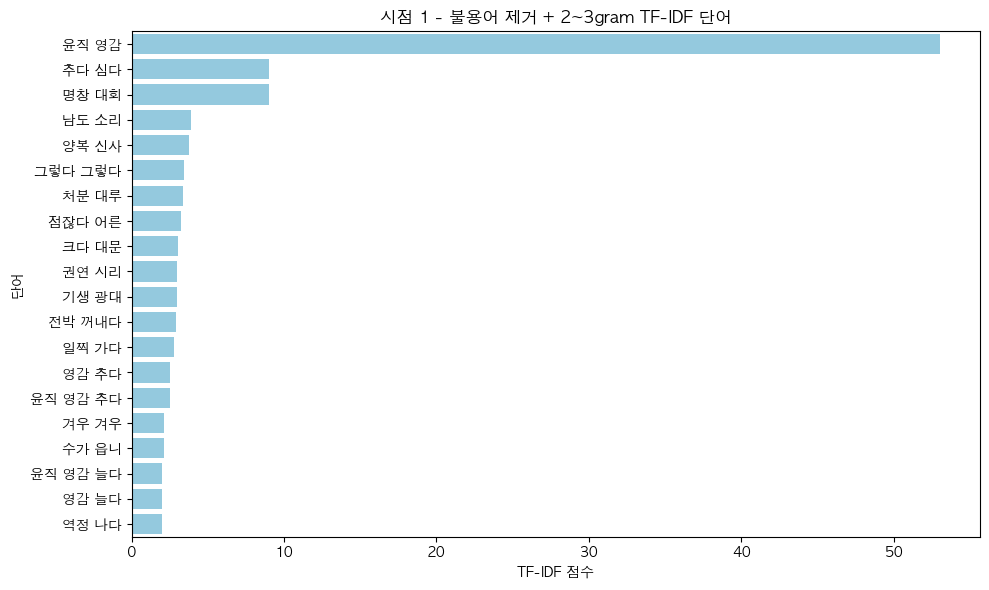

In [ ]:
# 불용어 리스트 
stopwords = set([
    "하다", "되다", "있다", "없다", "이다", "않다", "그", "저", "이", "것", "더", "또", "좀",
    "에게", "에서", "으로", "도", "는", "가", "를", "에", "의", "과", "와", "한", "중", "때",
    "그리고", "그러나", "그래서", "하지만","보다","허다","않다"
])

# 형태소 분석기 준비
okt = Okt()

def get_filtered_tokens(text):
    tokens = okt.pos(text, stem=True)
    return [word for word, tag in tokens if tag in ['Noun', 'Adjective', 'Verb'] and word not in stopwords]

file_path = "/Users/jeonghaheon/Documents/GitHub/taepyungcheonha-sentiment_text_analytics/data/태평천하_감정유형태깅_최종.csv"
df = pd.read_csv(file_path)

# 시점 1 범위 필터링
df_s1 = df[df["문장번호"] <= 549].dropna(subset=["문장내용"])

# 문장별 토큰 리스트
tokenized_docs = df_s1["문장내용"].apply(get_filtered_tokens).tolist()
joined_docs = [" ".join(tokens) for tokens in tokenized_docs]

# TF-IDF with bigram + trigram
vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=100)
X = vectorizer.fit_transform(joined_docs)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# TF-IDF 합산 기준 상위 20개 추출
top_keywords = tfidf_df.sum().sort_values(ascending=False).head(20)

# 시각화
plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, color="skyblue")
plt.title("시점 1 - 불용어 제거 + 2~3gram TF-IDF 단어")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()

import platform
if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

plt.show()


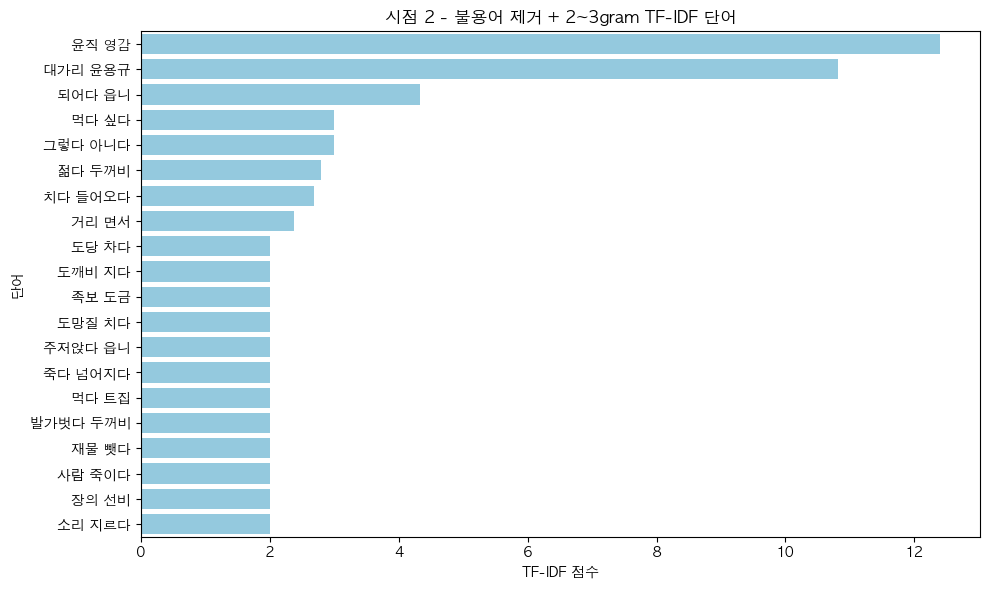

In [ ]:
# 시점 2 범위 필터링
df_s2 = df[(df["문장번호"] >= 550) & (df["문장번호"] <= 1100)].dropna(subset=["문장내용"])

# 문장별 토큰화 및 TF-IDF
tokenized_docs = df_s2["문장내용"].apply(get_filtered_tokens).tolist()
joined_docs = [" ".join(tokens) for tokens in tokenized_docs]

vectorizer = TfidfVectorizer(ngram_range=(2, 3), max_features=100)
X = vectorizer.fit_transform(joined_docs)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 상위 20개 키워드 시각화
top_keywords = tfidf_df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, color="skyblue")
plt.title("시점 2 - 불용어 제거 + 2~3gram TF-IDF 단어")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()

if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

plt.show()


잘 안되고 있는 느낌 

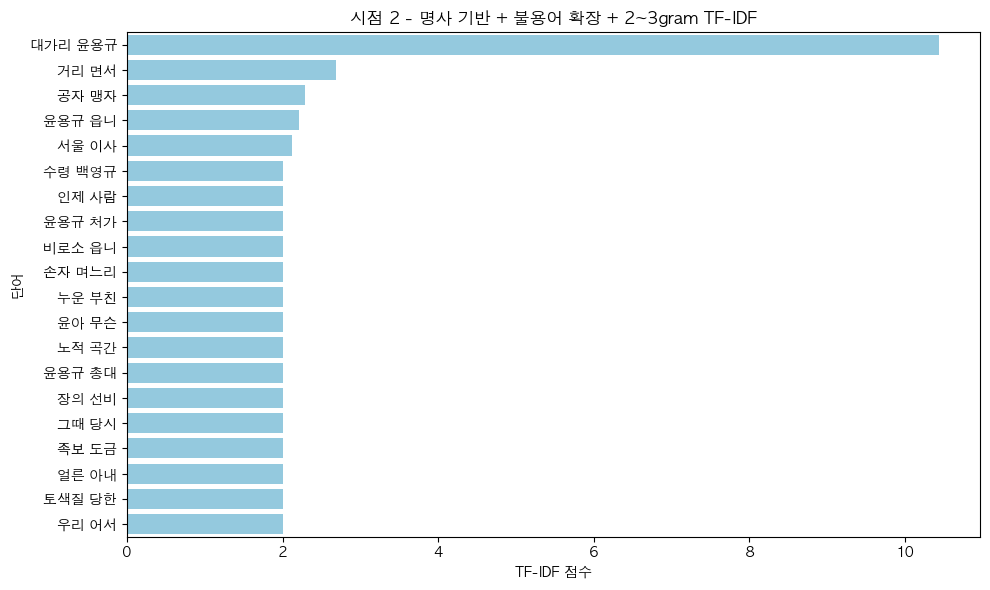

In [ ]:
# 개선 방안 반영
from sklearn.feature_extraction.text import TfidfVectorizer

# 인물명/고유명사 등 추가 불용어 반영
custom_stopwords = stopwords.union(set(["윤직", "영감", "양복", "신사", "그놈", "그자", "그년"]))

def clean_tokens(text):
    tokens = okt.pos(text, stem=True)
    # 명사만 살림
    return [word for word, tag in tokens if tag == "Noun" and word not in custom_stopwords]

# 시점 2 범위 필터링
df_s2 = df[(df["문장번호"] >= 550) & (df["문장번호"] <= 1100)].dropna(subset=["문장내용"])

# 문장별 토큰화
tokenized_docs = df_s2["문장내용"].apply(clean_tokens).tolist()
joined_docs = [" ".join(tokens) for tokens in tokenized_docs]

# TF-IDF 벡터라이저 설정: 명사 기반 2~3gram, 최소 2문장 이상에 등장한 것만
vectorizer = TfidfVectorizer(ngram_range=(2, 3), min_df=2, max_features=100)
X = vectorizer.fit_transform(joined_docs)
tfidf_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())

# 상위 키워드 시각화
top_keywords = tfidf_df.sum().sort_values(ascending=False).head(20)

plt.figure(figsize=(10, 6))
sns.barplot(x=top_keywords.values, y=top_keywords.index, color="skyblue")
plt.title("시점 2 - 명사 기반 + 불용어 확장 + 2~3gram TF-IDF")
plt.xlabel("TF-IDF 점수")
plt.ylabel("단어")
plt.tight_layout()

if platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'

plt.show()
